In [ ]:
import os
import json
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from huggingface_hub import hf_hub_download
import os, zipfile
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import torch
import random
from IPython.display import display
from jiwer import cer, wer

In [ ]:
with open(ann_train_path, "r", encoding="utf-8") as f:
    coco_train = json.load(f)

In [ ]:
translations = [ attr_v['translation']
 for ann in coco_train['annotations'] 
 for attr_k, attr_v in ann.items()
 if attr_k == 'attributes'
 ]

In [ ]:
with open(ann_train_path, "r", encoding="utf-8") as f:
    coco_train = json.load(f)

images_by_id = {img["id"]: img for img in coco_train["images"]}
anns_by_image = defaultdict(list)
for ann in coco_train["annotations"]:
    anns_by_image[ann["image_id"]].append(ann)

def polygon_to_bbox(segmentation, padding=2, img_width=None, img_height=None):
    """
    segmentation: formato COCO, puede ser:
      - [x1, y1, x2, y2, ...]
      - [[x1, y1, x2, y2, ...]]
    Devuelve bbox = (left, upper, right, lower)
    """
    if not segmentation:
        return None

    # Si viene como [[...]] nos quedamos con la primera lista
    coords = segmentation[0] if isinstance(segmentation[0], (list, tuple)) else segmentation

    xs = coords[0::2]
    ys = coords[1::2]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    # Aplicamos padding
    x_min = x_min - padding
    y_min = y_min - padding
    x_max = x_max + padding
    y_max = y_max + padding

    # Si tenemos tamaño de imagen, recortamos a los límites
    if img_width is not None and img_height is not None:
        x_min = max(0, min(x_min, img_width - 1))
        y_min = max(0, min(y_min, img_height - 1))
        x_max = max(0, min(x_max, img_width - 1))
        y_max = max(0, min(y_max, img_height - 1))

    # Aseguramos que right >= left y lower >= upper
    if x_max < x_min:
        x_min, x_max = x_max, x_min
    if y_max < y_min:
        y_min, y_max = y_max, y_min

    return (x_min, y_min, x_max, y_max)

def get_text_from_ann(ann):
    attrs = ann.get("attributes", {})
    trans = attrs.get("translation", "")
    if isinstance(trans, dict):
        return trans.get("en") or (list(trans.values())[0] if trans else "")
    return trans or ""

In [ ]:
# ejemplo: 1 página y 1 línea
sample_img_id = coco_train["images"][0]["id"]
img_info = images_by_id[sample_img_id]
img_path = os.path.join(images_dir, 'images', img_info["file_name"])

page = Image.open(img_path).convert("RGB")
plt.imshow(page)
plt.title(f"Page: {img_info['file_name']}")
plt.axis("off")

In [ ]:
page = Image.open(img_path).convert("RGB")
ann = anns_by_image[sample_img_id][0]

bbox = polygon_to_bbox(
    ann["segmentation"],padding=2,
    img_width=page.width,
    img_height=page.height
    )
crop = page.crop(bbox)
gt_text = get_text_from_ann(ann)

plt.imshow(crop)
plt.title(gt_text)
plt.axis("off")

In [ ]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)
model.eval()

def trocr_predict(image, max_length=128):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=max_length)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

pred = trocr_predict(crop)
print("GT  :", gt_text)
print("Pred:", pred)

In [ ]:
def sample_lines_from_coco(
    coco,
    images_by_id,
    anns_by_image,
    images_dir,
    n_lines=50,
):
    """
    Devuelve una lista de (imagen_recortada, texto_gt)
    tomada aleatoriamente de las páginas.
    """
    lines = []
    img_ids = list(images_by_id.keys())
    random.shuffle(img_ids)

    for img_id in img_ids:
        img_info = images_by_id[img_id]
        img_path = os.path.join(images_dir, 'images', img_info["file_name"])

        # abrimos la página solo una vez por imagen
        page = Image.open(img_path).convert("RGB")
        w, h = page.width, page.height

        for ann in anns_by_image[img_id]:
            text_gt = get_text_from_ann(ann)
            if not text_gt or len(text_gt.strip()) < 3:
                # saltamos textos vacíos o muy cortos
                continue

            bbox = polygon_to_bbox(
                ann["segmentation"],
                padding=2,
                img_width=w,
                img_height=h,
            )
            if bbox is None:
                continue

            left, upper, right, lower = bbox
            if right <= left or lower <= upper:
                # anotación mala, la saltamos
                continue

            crop = page.crop(bbox)
            lines.append((crop, text_gt))

            if len(lines) >= n_lines:
                return lines

    return lines

In [ ]:
lines = sample_lines_from_coco(
    coco_train,
    images_by_id,
    anns_by_image,
    images_dir,
    n_lines=50,   # puedes subir a 200, 500, etc.
)

len(lines)

In [ ]:
gts = []
preds = []

for i, (img_line, gt) in enumerate(lines, start=1):
    pred = trocr_predict(img_line)
    gts.append(gt)
    preds.append(pred)

    # mostramos los primeros 5 para inspección visual
    if i <= 5:
        print(f"\nEjemplo {i}")
        display(img_line)
        print("GT  :", gt)
        print("Pred:", pred)

print(f"\nTotal de líneas evaluadas: {len(gts)}")

In [ ]:
cer_value = cer(gts, preds)
wer_value = wer(gts, preds)

print("CER (Character Error Rate):", cer_value)
print("WER (Word Error Rate):     ", wer_value)

## Fine-Tunning

In [ ]:
import os
import json
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from huggingface_hub import hf_hub_download
import os, zipfile
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import torch
import random
from IPython.display import display
from jiwer import cer, wer
from torch.utils.data import DataLoader
from torch.optim import AdamW

In [ ]:
def get_text_from_ann(ann):
    attrs = ann.get("attributes", {})
    trans = attrs.get("translation", "")
    if isinstance(trans, dict):
        return trans.get("en") or (list(trans.values())[0] if trans else "")
    return trans or ""

def polygon_to_bbox(segmentation, padding=2, img_width=None, img_height=None):
    """
    segmentation: formato COCO, puede ser:
      - [x1, y1, x2, y2, ...]
      - [[x1, y1, x2, y2, ...]]
    Devuelve bbox = (left, upper, right, lower)
    """
    if not segmentation:
        return None

    # Si viene como [[...]] nos quedamos con la primera lista
    coords = segmentation[0] if isinstance(segmentation[0], (list, tuple)) else segmentation

    xs = coords[0::2]
    ys = coords[1::2]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    # Aplicamos padding
    x_min = x_min - padding
    y_min = y_min - padding
    x_max = x_max + padding
    y_max = y_max + padding

    # Si tenemos tamaño de imagen, recortamos a los límites
    if img_width is not None and img_height is not None:
        x_min = max(0, min(x_min, img_width - 1))
        y_min = max(0, min(y_min, img_height - 1))
        x_max = max(0, min(x_max, img_width - 1))
        y_max = max(0, min(y_max, img_height - 1))

    # Aseguramos que right >= left y lower >= upper
    if x_max < x_min:
        x_min, x_max = x_max, x_min
    if y_max < y_min:
        y_min, y_max = y_max, y_min

    return (x_min, y_min, x_max, y_max)

In [ ]:
REPO_ID = "ai-forever/school_notebooks_EN"
os.makedirs("data/notebooks_en", exist_ok=True)

ann_train_path = hf_hub_download(
    repo_id=REPO_ID,
    filename="annotations_train.json",
    repo_type="dataset",          
    local_dir="data/notebooks_en",
)

ann_val_path = hf_hub_download(
    repo_id=REPO_ID,
    filename="annotations_val.json",
    repo_type="dataset",
    local_dir="data/notebooks_en",
)

ann_test_path = hf_hub_download(
    repo_id=REPO_ID,
    filename="annotations_test.json",
    repo_type="dataset",
    local_dir="data/notebooks_en",
)

images_zip_path = hf_hub_download(
    repo_id=REPO_ID,
    filename="images.zip",
    repo_type="dataset",
    local_dir="data/notebooks_en",
)

images_dir = "data/notebooks_en/images"
os.makedirs(images_dir, exist_ok=True)

with zipfile.ZipFile(images_zip_path, "r") as zf:
    zf.extractall(images_dir)

In [ ]:
# Cargar COCO train y val
with open(ann_train_path, "r", encoding="utf-8") as f:
    coco_train = json.load(f)

with open(ann_val_path, "r", encoding="utf-8") as f:
    coco_val = json.load(f)

def build_index(coco):
    images_by_id = {img["id"]: img for img in coco["images"]}
    anns_by_image = defaultdict(list)
    for ann in coco["annotations"]:
        anns_by_image[ann["image_id"]].append(ann)
    return images_by_id, anns_by_image

train_images_by_id, train_anns_by_image = build_index(coco_train)
val_images_by_id,   val_anns_by_image   = build_index(coco_val)

In [ ]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Device:", device)

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Alinear config básica
model.config.eos_token_id = processor.tokenizer.eos_token_id
model.config.bos_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.to(device)
model.train()

for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
def build_line_samples(
    coco,
    images_by_id,
    anns_by_image,
    images_dir,
    max_lines=1000,
):
    samples = []
    img_ids = list(images_by_id.keys())

    for img_id in img_ids:
        img_info = images_by_id[img_id]
        img_path = os.path.join(images_dir,'images', img_info["file_name"])
        page = Image.open(img_path).convert("RGB")
        w, h = page.width, page.height

        for ann in anns_by_image[img_id]:
            text = get_text_from_ann(ann)
            if not text or len(text.strip()) < 3:
                continue

            bbox = polygon_to_bbox(
                ann["segmentation"],
                padding=2,
                img_width=w,
                img_height=h,
            )
            if bbox is None:
                continue

            left, upper, right, lower = bbox
            if right <= left or lower <= upper:
                continue

            crop = page.crop(bbox)

            samples.append({
                "image": crop,
                "text": text.strip(),
            })

            if len(samples) >= max_lines:
                return samples
    return samples

In [ ]:
train_samples = build_line_samples(
    coco_train,
    train_images_by_id,
    train_anns_by_image,
    images_dir,
    max_lines=2000,   # p.ej. 2k líneas para entrenar
)

val_samples = build_line_samples(
    coco_val,
    val_images_by_id,
    val_anns_by_image,
    images_dir,
    max_lines=400,    # p.ej. 400 para validar
)

len(train_samples), len(val_samples)

In [ ]:
train_ds = Dataset.from_list(train_samples)
val_ds   = Dataset.from_list(val_samples)

def preprocess_example(example):
    img = example["image"].convert("RGB")
    text = example["text"]

    # Imagen -> pixel_values
    pixel_values = processor(images=img, return_tensors="pt").pixel_values[0]

    # Texto -> ids
    labels = processor.tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt",
    ).input_ids[0]

    example["pixel_values"] = pixel_values
    example["labels"] = labels
    return example

train_ds_proc = train_ds.map(preprocess_example)
val_ds_proc   = val_ds.map(preprocess_example)

# Nos quedamos solo con pixel_values y labels
train_ds_proc = train_ds_proc.remove_columns(["image", "text"])
val_ds_proc   = val_ds_proc.remove_columns(["image", "text"])

train_ds_proc.set_format(type="torch")
val_ds_proc.set_format(type="torch")

print(train_ds_proc[0])

In [ ]:
labels0 = train_ds_proc[10]["labels"]
print("Primeros 20 ids:", labels0[:20].tolist())
print("Texto decodificado:", processor.tokenizer.decode([int(i) for i in labels0 if i != processor.tokenizer.pad_token_id]))

In [ ]:
pad_token_id = processor.tokenizer.pad_token_id

def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    labels = torch.stack([b["labels"] for b in batch])
    labels[labels == pad_token_id] = -100

    return {
        "pixel_values": pixel_values.to(device),
        "labels": labels.to(device),
    }

train_loader = DataLoader(train_ds_proc, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds_proc, batch_size=4, shuffle=False, collate_fn=collate_fn)

batch = next(iter(train_loader))
print("pixel_values:", batch["pixel_values"].shape)
print("labels:", batch["labels"].shape)

In [ ]:
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=1e-5)

num_epochs = 1  # empieza con 1 epoch
print_every = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for step, batch in enumerate(train_loader, start=1):
        optimizer.zero_grad()

        outputs = model(
            pixel_values=batch["pixel_values"],
            labels=batch["labels"],
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % print_every == 0:
            avg_loss = total_loss / print_every
            print(f"Epoch {epoch+1} | Step {step} | Loss: {avg_loss:.4f}")
            total_loss = 0.0

    # pequeña evaluación de loss en val (opcional)
    model.eval()
    val_loss = 0.0
    num_val_steps = 0

    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                pixel_values=batch["pixel_values"],
                labels=batch["labels"],
            )
            val_loss += outputs.loss.item()
            num_val_steps += 1

    print(f"Epoch {epoch+1} finalizada | Val loss: {val_loss / max(1, num_val_steps):.4f}")


In [ ]:
def trocr_predict(image, max_length=128):
    image = image.convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=max_length)

    pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return pred.strip()

In [ ]:
gts = []
preds = []

N = 100  # número de líneas para evaluación

for i, sample in enumerate(val_samples[:N], start=1):
    img_line = sample["image"]
    gt_text = sample["text"]

    pred_text = trocr_predict(img_line)

    gts.append(gt_text)
    preds.append(pred_text)

    if i%5 == 0:
        print(f"\nEjemplo {i}")
        display(img_line)
        print("GT  :", gt_text)
        print("Pred:", pred_text)

print("\n--- Métricas modelo fine-tuneado ---")
print("CER:", cer(gts, preds))
print("WER:", wer(gts, preds))

In [ ]:
import random
import pandas as pd 

for s in random.sample(train_samples, 5):
    display(s["image"])
    print(repr(s["text"]))

lengths = [len(s["text"]) for s in train_samples]
pd.Series(lengths).value_counts().plot(kind='bar')

#### Resultados Fine Tunning
- Modelo Base
CER: 0.4489051094890511
WER:  1.04

- Modelo Fine-Tunning
CER: 0.10469314079422383
WER: 0.24

In [ ]:
page_id = coco_val["images"][0]["id"]


In [ ]:
val_anns_by_image[page_id]

In [ ]:
SAVE_DIR = "./trocr_notebooks_ft"
os.makedirs(SAVE_DIR, exist_ok=True)

model.save_pretrained(SAVE_DIR)
processor.save_pretrained(SAVE_DIR)
print("Modelo y processor guardados en:", SAVE_DIR)

In [ ]:
coco_train.keys()

In [ ]:
coco_train['categories']
categories_dict = {cat['id']:cat['name'] for cat in coco_train['categories']}

In [ ]:
coco_train['images']
image_name_dict = {image['id']:image['file_name'] for image in coco_train['images']}
image_name_dict

In [ ]:
coco_train['annotations']

In [ ]:
from pathlib import Path
import cv2
import numpy as np
import PIL

In [ ]:
def crop_polygon_cv2(img_path, polygon_points):
    img = cv2.imread(img_path)
    pts = np.array(polygon_points, dtype=np.int32)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)  
    masked = cv2.bitwise_and(img, img, mask=mask)
    x, y, w, h = cv2.boundingRect(pts)
    cropped = masked[y:y+h, x:x+w]
    return cropped

In [ ]:
### Todas las anotaciones de un imagen
img_id = 0
annotations = coco_train['annotations']
ann = annotations[0]
segmentation = ann['segmentation']
coords = segmentation[0] if isinstance(segmentation[0], (list, tuple)) else segmentation
images_name = image_name_dict[ann['image_id']]
img_path = Path(images_dir)/'images'/images_name
print(ann['attributes']['translation'])
img_ann = crop_polygon_cv2(img_path,coords)
Image.fromarray(img_ann)

In [ ]:
def get_text_from_ann(ann):
    attrs = ann.get("attributes", {})
    trans = attrs.get("translation", "")
    if isinstance(trans, dict):
        return trans.get("en") or (list(trans.values())[0] if trans else "")
    return trans or ""

def get_image_coords(ann):
    segmentation = ann.get("segmentation",[])
    coords = segmentation[0] if isinstance(segmentation[0], (list, tuple)) else segmentation
    return coords

def crop_polygon_cv2(img_path, coords):
    img = cv2.imread(img_path)
    polygon_points = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
    pts = np.array(polygon_points, dtype=np.int32)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)  
    masked = cv2.bitwise_and(img, img, mask=mask)
    x, y, w, h = cv2.boundingRect(pts)
    cropped = masked[y:y+h, x:x+w]
    return cropped

In [ ]:
def extract_samples(coco_json_file,
                    images_dir = 'data/notebooks_en/images'
                    ):
    categories_dict = {cat['id']:cat['name'] for cat in coco_json_file['categories']}
    image_name_dict = {image['id']:image['file_name'] for image in coco_json_file['images']}
    annotations = coco_json_file['annotations']
    
    words = []
    for ann in annotations:
        text_gt = get_text_from_ann(ann)
        if not text_gt or len(text_gt.strip()) < 3:
            continue
        
        images_name = image_name_dict[ann['image_id']]
        img_path = Path(images_dir)/'images'/images_name
        coords = get_image_coords(ann)
        crop = crop_polygon_cv2(img_path,coords)
        words.append((Image.fromarray(crop), text_gt))

    return words

In [ ]:
words = extract_samples(coco_train)

In [ ]:
len(words)

## Fine-Tunning con Seq2Seg

In [2]:
import pickle

In [3]:
with open("./ocr-notebooks/data/02_intermediate/train_line_samples.pkl", "rb") as f:
    train_samples = pickle.load(f)
    train_samples = train_samples[0:2000]

In [4]:
with open("./ocr-notebooks/data/02_intermediate/val_line_samples.pkl", "rb") as f:
    val_samples = pickle.load(f)
    val_samples = val_samples[0:400]

In [24]:
with open("./ocr-notebooks/data/02_intermediate/test_line_samples.pkl", "rb") as f:
    test_samples = pickle.load(f)
    test_samples = test_samples[0:400]

In [5]:
len(train_samples), len(val_samples)

(2000, 400)

In [26]:
from typing import Any, Dict, List
from dataclasses import asdict
from torch.utils.data import Dataset
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)
import json
import evaluate
from torch.utils.data import DataLoader
import torch
from jiwer import cer, wer

class NotebooksDataset(Dataset):
    def __init__(
    self,
    samples: List[Dict[str, Any]],
    processor: TrOCRProcessor,
    max_target_length: int,
    ) -> None:
        self.samples = samples
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        sample = self.samples[idx]
        image = sample["image"]
        text = sample["text"]

        pixel_values = self.processor(
            images=image,
            return_tensors="pt",
        ).pixel_values

        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": labels.squeeze(),
        }

In [15]:
pretrained_model_name = "microsoft/trocr-base-handwritten"
device = "mps" if torch.backends.mps.is_available() else "cpu"

processor = TrOCRProcessor.from_pretrained(pretrained_model_name)
model = VisionEncoderDecoderModel.from_pretrained(pretrained_model_name).to(device)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

train_dataset = NotebooksDataset(train_samples,processor,128)
val_dataset = NotebooksDataset(val_samples,processor,128)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


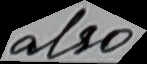

In [18]:
train_samples[0].get('image')

In [19]:
labels = encoding['labels'][0]
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

In [30]:
cer_metric = evaluate.load('cer')

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}


training_args = Seq2SeqTrainingArguments(
    auto_find_batch_size=True,
    do_train=True,
    do_eval=True,
    predict_with_generate=True,

    fp16=False,
    fp16_full_eval=False,

    overwrite_output_dir=True,
    output_dir="ocr-notebooks/data/06_models/trocr-line-hf",
    num_train_epochs = 1,

    eval_strategy='steps',
    save_strategy='steps',
    logging_strategy='steps',

    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    warmup_steps=100,

    save_total_limit=5,

    gradient_accumulation_steps=4,
    gradient_checkpointing=True,

    optim='adafactor',
    load_best_model_at_end=True,

    metric_for_best_model='eval_cer',
    greater_is_better=False,
    report_to='none',
)
    


trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

trainer.train()
metrics = trainer.evaluate()

/var/folders/f8/dhdkzbzd1sj880s0zn4sbb0c0000gn/T/ipykernel_20611/2590304962.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/Users/sergio/Documents/OCR_project/ocr_venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [21]:
metrics

{'eval_loss': 1.708770751953125,
 'eval_cer': 0.25865128660159714,
 'eval_runtime': 24.8015,
 'eval_samples_per_second': 16.128,
 'eval_steps_per_second': 2.016,
 'epoch': 1.0}

In [23]:
def trocr_predict(image, max_length=128):
    image = image.convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=max_length)

    pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return pred.strip()


Ejemplo 5


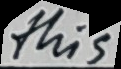

GT  : this
Pred: this

Ejemplo 10


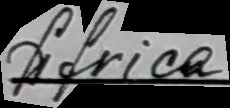

GT  : Africa
Pred: fil

Ejemplo 15


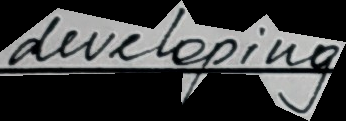

GT  : developing
Pred: dupling

Ejemplo 20


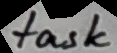

GT  : task
Pred: task

Ejemplo 25


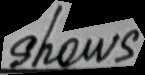

GT  : shows
Pred: shows

Ejemplo 30


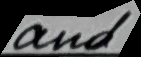

GT  : and
Pred: and

Ejemplo 35


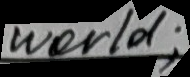

GT  : world;
Pred: world

Ejemplo 40


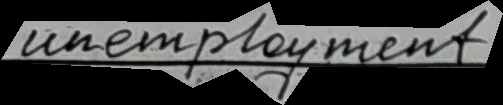

GT  : unemployment
Pred: un

Ejemplo 45


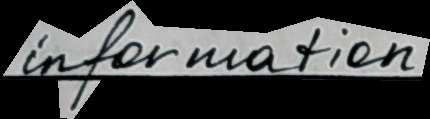

GT  : information
Pred: information

Ejemplo 50


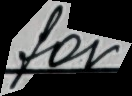

GT  : for
Pred: for

Ejemplo 55


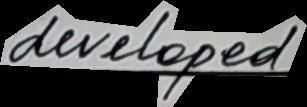

GT  : developed
Pred: dupled

Ejemplo 60


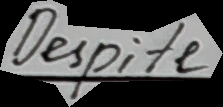

GT  : Despite
Pred: lupite

Ejemplo 65


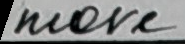

GT  : more
Pred: will

Ejemplo 70


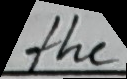

GT  : the
Pred: the

Ejemplo 75


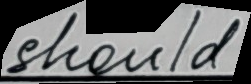

GT  : should
Pred: should

Ejemplo 80


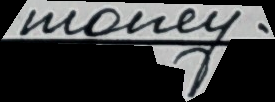

GT  : money.
Pred: many

Ejemplo 85


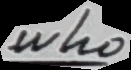

GT  : who
Pred: who

Ejemplo 90


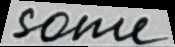

GT  : some
Pred: some

Ejemplo 95


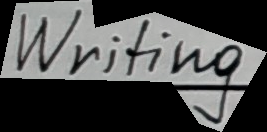

GT  : Writing
Pred: Writing

Ejemplo 100


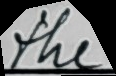

GT  : the
Pred: the

--- Métricas modelo fine-tuneado ---
CER: 0.3094017094017094
WER: 0.5


In [27]:
gts = []
preds = []

N = 100  # número de líneas para evaluación

for i, sample in enumerate(test_samples[:N], start=1):
    img_line = sample["image"]
    gt_text = sample["text"]

    pred_text = trocr_predict(img_line)

    gts.append(gt_text)
    preds.append(pred_text)

    if i%5 == 0:
        print(f"\nEjemplo {i}")
        display(img_line)
        print("GT  :", gt_text)
        print("Pred:", pred_text)

print("\n--- Métricas modelo fine-tuneado ---")
print("CER:", cer(gts, preds))
print("WER:", wer(gts, preds))

